# Laboratory of Computational Physics mod.B

## Fifth assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

The aim of this notebook is to implement some techniques of unsupervised learning, in particular, the one concerning clustering.

In [1]:
#import packages
import numpy as np
import pandas as pd

from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from IPython.display import Latex

## For spin = True:

In [2]:
q=0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])
    
print('.....')


SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

for n in range(10):
    print(v[n])
    
print('.....')

each of N=10000data samples has L=8 digits
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
.....
[-1  1 -1 -1  1 -1  1  1]
[ 1  1 -1  1  1 -1 -1  1]
[-1  1  1  1 -1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1 -1]
[ 1  1 -1 -1  1 -1 -1 -1]
[-1  1  1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1 -1  1  1]
[ 1 -1 -1  1  1  1 -1  1]
[ 1 -1 -1 -1 -1 -1  1 -1]
.....


In [3]:
# n hidden units
M = 3
sigma = np.sqrt(4. / float(N+M))
np.random.seed(12345)
w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print('w=',w)
print('a=',a)
print('b=',b)

w= [[ 0.01718207 -0.00734388 -0.01264135]
 [-0.01181582  0.00270859  0.00382121]
 [ 0.01857779  0.00612617  0.00995477]
 [ 0.00614187  0.00990711  0.0184495 ]
 [-0.01966152 -0.01573986 -0.00805064]
 [ 0.00625551  0.01239064  0.0148848 ]
 [ 0.01858312  0.00894607  0.00569816]
 [ 0.00869684 -0.00129585 -0.00697557]]
a= [-0.00241385  0.00918619  0.01975762  0.00707389  0.01163116 -0.01316146
 -0.01892319  0.01201301]
b= [0. 0. 0.]


In [4]:
def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5 #per avere y tra -0.5 e 0.5
    return (x,y)

def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(M, epoch=0):
    A = 2. / w.max()
    (x1, y1) = create_coord(L,0)
    (x2, y2) = create_coord(M,1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i,j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i,j]))
    A = 300./(a.max()+b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*np.abs(a[i]), zorder=2, c=mycolor(a[i]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*np.abs(b[j]), zorder=2, c=mycolor(b[j]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
    return(v_out)

def mean_square_increment(dw):
    total = 0
    for i in range(L):
        for j in range(M):
            total += dw[i,j]**2
    total /= L*M
    return total

dw= [[-0.084 -0.036 -0.168]
 [-0.068 -0.108  0.008]
 [ 0.096 -0.032  0.132]
 [-0.028  0.116  0.016]
 [-0.036 -0.028  0.056]
 [ 0.008 -0.04   0.052]
 [-0.104  0.136 -0.132]
 [-0.06  -0.02   0.016]]
da= [-0.036 -0.052  0.016 -0.076 -0.028  0.056  0.024  0.02 ]
db= [-0.072  0.096  0.012]
dw= [[-0.01904762 -0.06095238  0.0152381 ]
 [-0.02666667 -0.03809524  0.0152381 ]
 [-0.02666667  0.08380952 -0.05333333]
 [ 0.03047619  0.07238095 -0.03428571]
 [ 0.05714286  0.07619048 -0.02285714]
 [ 0.01142857  0.03047619  0.02285714]
 [ 0.08        0.06095238  0.00761905]
 [-0.00380952 -0.08380952  0.06095238]]
da= [-0.02285714 -0.06095238 -0.06095238  0.04952381 -0.0152381  -0.00761905
  0.          0.0152381 ]
db= [ 0.00380952  0.03047619 -0.00761905]


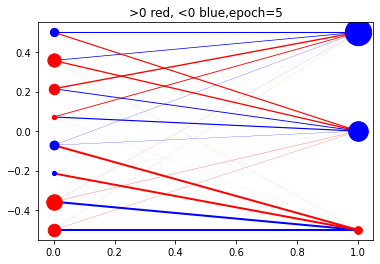

 l_rate= 0.7999999999999998


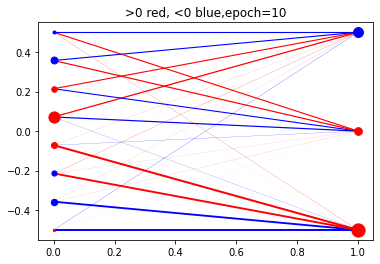

 l_rate= 0.6666666666666663


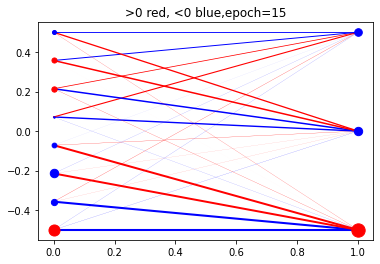

 l_rate= 0.5714285714285713


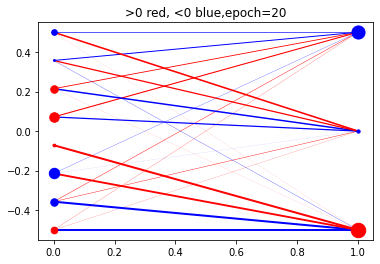

 l_rate= 0.5


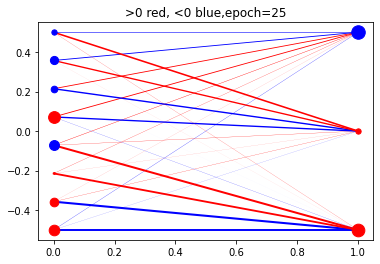

 l_rate= 0.4444444444444445


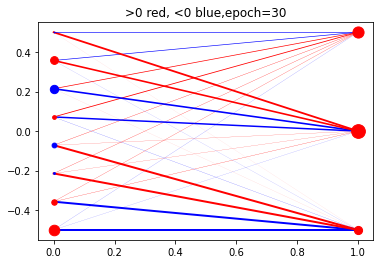

 l_rate= 0.4000000000000001


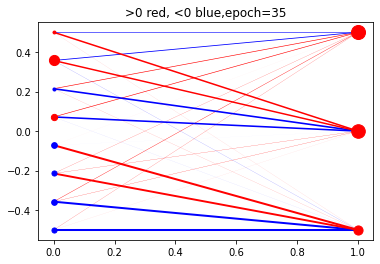

 l_rate= 0.3636363636363637


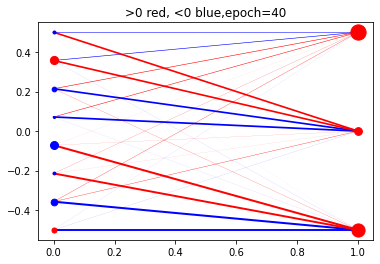

 l_rate= 0.3333333333333335


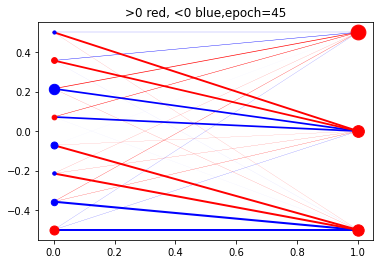

 l_rate= 0.3076923076923079


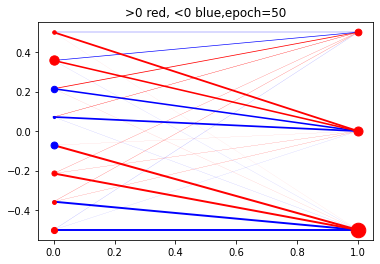

 l_rate= 0.28571428571428586


In [5]:
np.random.seed(12345)

#def generation(beta, l_rate = 1.0, regularization):

#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_spin = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_spin[epoch-1] = mean_square_increment(dw)
            if epoch <= 2 and n <= mini:
                #print('.... epoch =', epoch, '  n=', n, '   m='m)
                print('dw=', dw)
                print('da=', da)
                print('db=', db)

            w += dw
            a += da
            b += db
            m = 0
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 5 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

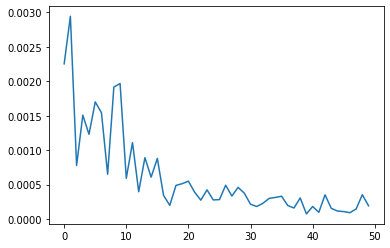

In [6]:
plt.plot(np.arange(nepoch),weights_spin)

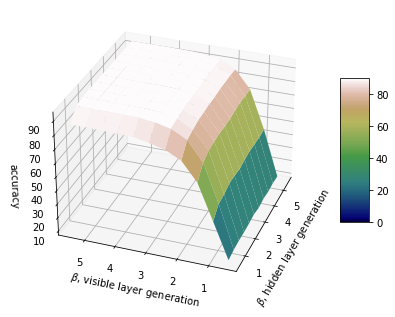

In [7]:
q1=0   #Probability of corruption for perfectly-generated data

fname='DATA/dataRBM_q'+str(q1)+'.csv'
v= np.loadtxt(fname, delimiter=',', dtype=int)
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0_incurr = np.copy(v)

def evaluate_beta(beta2, v0, v_incurr, beta1=1):
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta1)
        v2[n] = activate(h, w.T,a,GAP*beta2)
    
    vdiff = np.sum(np.abs(v_incurr-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_incurr))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_incurr) * 100
    
    return tot, perc 



n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[i], v0, v0_incurr, beta1=betas[j])
        tots[i,j] = tot
        percs[i, j] = perc 

        
        
x, y = np.meshgrid(betas, betas)
#fig, ax = plt.subplots(1,1, figsize=(10,6))

fig = plt.figure()
ax = Axes3D(fig)


# Plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=0.,vmax=90., cmap='gist_earth')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$\\beta$, hidden layer generation')
ax.set_ylabel('$\\beta$, visible layer generation')
ax.set_zlabel('accuracy')

ax.view_init(30,200)


plt.show()

## For spin = False

In [8]:
q=0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])
    
print('.....')


SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

for n in range(10):
    print(v[n])
    
print('.....')

each of N=10000data samples has L=8 digits
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
.....
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
.....


In [9]:
# n hidden units
M = 3
sigma = np.sqrt(4. / float(N+M))
np.random.seed(12345)
w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print('w=',w)
print('a=',a)
print('b=',b)

w= [[ 0.01718207 -0.00734388 -0.01264135]
 [-0.01181582  0.00270859  0.00382121]
 [ 0.01857779  0.00612617  0.00995477]
 [ 0.00614187  0.00990711  0.0184495 ]
 [-0.01966152 -0.01573986 -0.00805064]
 [ 0.00625551  0.01239064  0.0148848 ]
 [ 0.01858312  0.00894607  0.00569816]
 [ 0.00869684 -0.00129585 -0.00697557]]
a= [-0.00241385  0.00918619  0.01975762  0.00707389  0.01163116 -0.01316146
 -0.01892319  0.01201301]
b= [0. 0. 0.]


dw= [[-0.048  0.008 -0.044]
 [-0.044 -0.012  0.004]
 [ 0.012  0.02   0.036]
 [-0.038  0.038 -0.014]
 [-0.022  0.02   0.008]
 [ 0.002  0.032  0.03 ]
 [-0.042  0.058 -0.026]
 [-0.032  0.022  0.008]]
da= [-0.014 -0.022  0.006 -0.034 -0.002  0.02   0.004  0.01 ]
db= [-0.038  0.05   0.   ]
dw= [[-0.02285714  0.03428571  0.00190476]
 [-0.04        0.02666667 -0.00571429]
 [ 0.00190476  0.02095238 -0.04190476]
 [ 0.03428571  0.06666667 -0.00380952]
 [ 0.01142857  0.03809524  0.00190476]
 [ 0.00380952  0.03047619  0.01904762]
 [-0.02285714  0.04       -0.01142857]
 [-0.00952381  0.0247619  -0.01142857]]
da= [ 0.01714286  0.         -0.0552381   0.02095238  0.00571429  0.03428571
 -0.01714286  0.00571429]
db= [-0.02285714  0.05333333 -0.0152381 ]


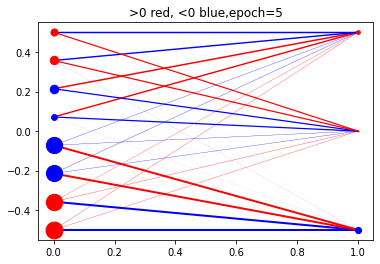

 l_rate= 0.7999999999999998


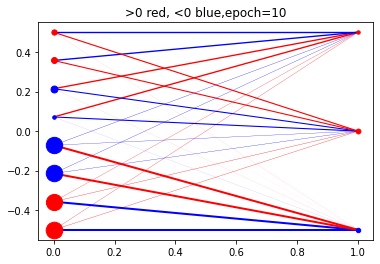

 l_rate= 0.6666666666666663


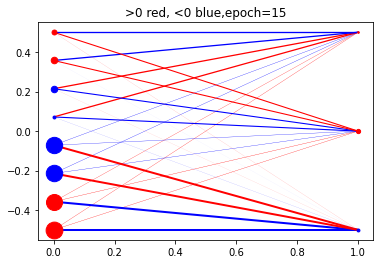

 l_rate= 0.5714285714285713


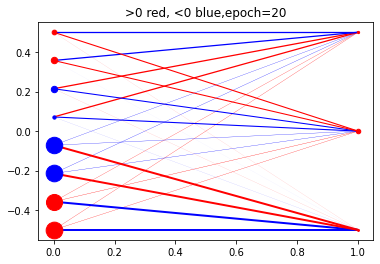

 l_rate= 0.5


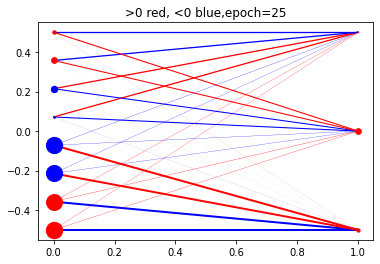

 l_rate= 0.4444444444444445


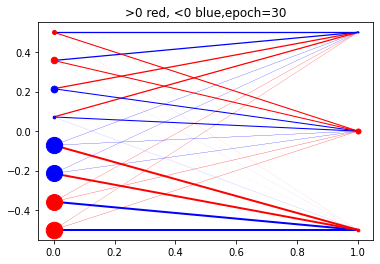

 l_rate= 0.4000000000000001


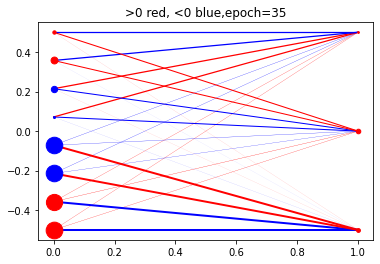

 l_rate= 0.3636363636363637


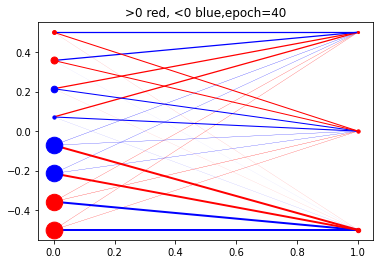

 l_rate= 0.3333333333333335


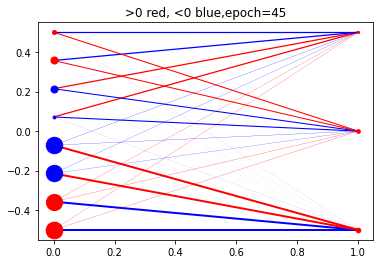

 l_rate= 0.3076923076923079


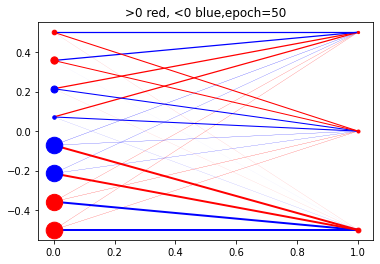

 l_rate= 0.28571428571428586


In [10]:
np.random.seed(12345)

#def generation(beta, l_rate = 1.0, regularization):

#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_bit = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_bit[epoch-1] = mean_square_increment(dw)
            if epoch <= 2 and n <= mini:
                #print('.... epoch =', epoch, '  n=', n, '   m='m)
                print('dw=', dw)
                print('da=', da)
                print('db=', db)

            w += dw
            a += da
            b += db
            m = 0
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 5 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

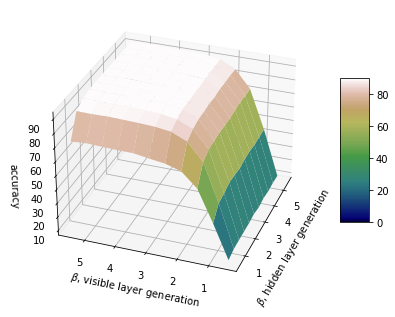

In [11]:
q1=0   #Probability of corruption for perfectly-generated data

fname='DATA/dataRBM_q'+str(q1)+'.csv'
v= np.loadtxt(fname, delimiter=',', dtype=int)
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0_incurr = np.copy(v)

def evaluate_beta(beta2, v0, v_incurr, beta1=1):
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta1)
        v2[n] = activate(h, w.T,a,GAP*beta2)
    
    vdiff = np.sum(np.abs(v_incurr-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_incurr))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_incurr) * 100
    
    return tot, perc 



n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[i], v0, v0_incurr, beta1=betas[j])
        tots[i,j] = tot
        percs[i, j] = perc 

        
        
x, y = np.meshgrid(betas, betas)
#fig, ax = plt.subplots(1,1, figsize=(10,6))

fig = plt.figure()
ax = Axes3D(fig)


# Plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=0.,vmax=90., cmap='gist_earth')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$\\beta$, hidden layer generation')
ax.set_ylabel('$\\beta$, visible layer generation')
ax.set_zlabel('accuracy')

ax.view_init(30,200)


plt.show()

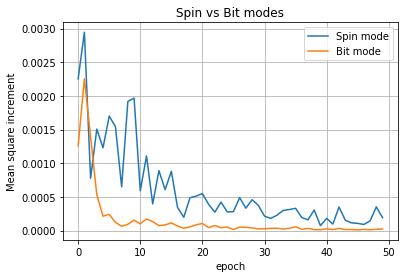

In [12]:
plt.plot(np.arange(nepoch),weights_spin, label = "Spin mode")
plt.plot(np.arange(nepoch),weights_bit, label = "Bit mode")
plt.xlabel('epoch')
plt.ylabel('Mean square increment')
plt.title('Spin vs Bit modes')
plt.grid()
plt.legend()
plt.show()

## With 5 sequences:

In [13]:
q=0.1

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])
    
print('.....')

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

for n in range(10):
    print(v[n])
    
print('.....')

each of N=10000data samples has L=8 digits
[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 1]
[1 0 1 1 1 1 0 0]
[1 0 1 1 1 1 1 1]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]
.....
[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 1]
[1 0 1 1 1 1 0 0]
[1 0 1 1 1 1 1 1]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]
.....


In [14]:
# n hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))
np.random.seed(12345)
w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print('w=',w)
print('a=',a)
print('b=',b)

w= [[ 0.01718207 -0.00734388 -0.01264135]
 [-0.01181582  0.00270859  0.00382121]
 [ 0.01857779  0.00612617  0.00995477]
 [ 0.00614187  0.00990711  0.0184495 ]
 [-0.01966152 -0.01573986 -0.00805064]
 [ 0.00625551  0.01239064  0.0148848 ]
 [ 0.01858312  0.00894607  0.00569816]
 [ 0.00869684 -0.00129585 -0.00697557]]
a= [-0.00241385  0.00918619  0.01975762  0.00707389  0.01163116 -0.01316146
 -0.01892319  0.01201301]
b= [0. 0. 0.]


dw= [[ 0.     0.018  0.054]
 [ 0.062  0.032  0.066]
 [ 0.064  0.028  0.034]
 [ 0.044  0.02   0.068]
 [ 0.02   0.052  0.048]
 [ 0.066  0.034  0.064]
 [-0.002  0.038  0.048]
 [ 0.046  0.082  0.086]]
da= [0.054 0.09  0.082 0.098 0.05  0.106 0.048 0.108]
db= [ 0.002 -0.024  0.03 ]
dw= [[-0.01142857  0.01904762  0.00761905]
 [ 0.01333333  0.00380952  0.0247619 ]
 [ 0.04190476  0.03809524 -0.00952381]
 [ 0.06666667  0.05904762  0.02095238]
 [ 0.00761905 -0.00761905  0.02857143]
 [ 0.03809524 -0.00761905  0.03047619]
 [ 0.01714286  0.03047619 -0.00761905]
 [ 0.02666667  0.02095238  0.00761905]]
da= [-0.00761905  0.          0.0152381   0.06285714  0.00571429  0.00571429
  0.0152381   0.00571429]
db= [0.02095238 0.00761905 0.00952381]


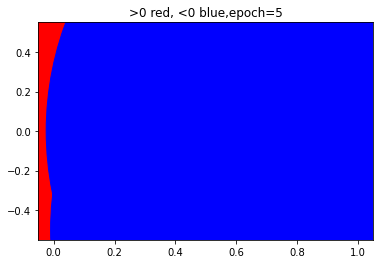

 l_rate= 0.7999999999999998


/usr/local/lib/python3.9/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.6666666666666663


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.5714285714285713


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.5


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.4444444444444445


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.4000000000000001


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.3636363636363637


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.3333333333333335


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.3076923076923079


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

 l_rate= 0.28571428571428586


In [15]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            if epoch <= 2 and n <= mini:
                #print('.... epoch =', epoch, '  n=', n, '   m='m)
                print('dw=', dw)
                print('da=', da)
                print('db=', db)

            w += dw
            a += da
            b += db
            m = 0
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 5 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

In [16]:
q1=0.0   #Probability of corruption for perfectly-generated data

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_incurr = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0_incurr = np.copy(v)

def evaluate_beta(beta2, v0, v_incurr, beta1=1):
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta1)
        v2[n] = activate(h, w.T,a,GAP*beta2)
    
    vdiff = np.sum(np.abs(v_incurr-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_incurr))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_incurr) * 100
    
    return tot, perc 
        




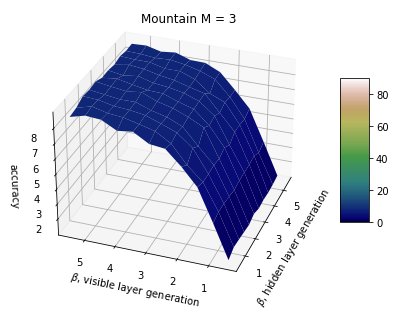

In [17]:
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[i], v0, v0_incurr, beta1=betas[j])
        tots[i,j] = tot
        percs[i, j] = perc 

                
x, y = np.meshgrid(betas, betas)
#fig, ax = plt.subplots(1,1, figsize=(10,6))

fig = plt.figure()
ax = Axes3D(fig)


# Plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=0.,vmax=90., cmap='gist_earth')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$\\beta$, hidden layer generation')
ax.set_ylabel('$\\beta$, visible layer generation')
ax.set_zlabel('accuracy')
fig.suptitle(f'Mountain M = {M}')

ax.view_init(30,200)


plt.show()